In [ ]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
# Function for data preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions and hashtags
    text = re.sub(r'@[^\s]+|#', '', text)
    # Remove special characters and numbers
    text = re.sub(r'\W+', ' ', text)
    return text.strip()

In [ ]:
# Load feature matrices and labels from .dat files
training_features = np.fromfile('/content/training_features_matrix.dat', dtype=np.float32)
training_labels = np.fromfile('/content/training_labels.dat', dtype=np.int32)
testing_features = np.fromfile('/content/testing_features_matrix.dat', dtype=np.float32)
testing_labels = np.fromfile('/content/testing_labels.dat', dtype=np.int32)


In [ ]:
# Load text data from training_data folder
train_legitimate_users_following = pd.read_csv('/content/legitimate_users_followings.txt', header=None, names=['following'], sep=',')


In [ ]:
import pandas as pd

# Read legitimate users' tweets with tab separator and specify the encoding
train_legitimate_users_tweets = pd.read_csv('/content/legitimate_users_tweets.txt', sep='\t', encoding='latin-1', header=None, names=['user_id', 'tweets', 'timestamp'], error_bad_lines=False)


# Read legitimate users with default separator (comma)
train_legitimate_users = pd.read_csv('/content/legitimate_users.txt', encoding='latin-1', header=None, names=['user_id'])

# Read spammers' following with comma separator and specify the encoding
train_spammers_following = pd.read_csv('/content/spammers_following.txt', sep=',', encoding='latin-1', header=None, names=['following'])


<ipython-input-64-d87cbe378f44>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  train_legitimate_users_tweets = pd.read_csv('/content/legitimate_users_tweets.txt', sep='\t', encoding='latin-1', header=None, names=['user_id', 'tweets', 'timestamp'], error_bad_lines=False)
Skipping line 36543: expected 4 fields, saw 5



In [ ]:
#train_spammers_tweets = pd.read_csv('/Users/macvision/tauseef/twitter_scam_detection/archive/Training_data/spammers_tweets.txt', header=None, names=['tweets'], sep=',')
train_spammers_tweets = pd.read_csv('/content/spammers_tweets.txt', sep='\t', encoding='utf-8', header=None, names=['user_id', 'tweets', 'timestamp'], error_bad_lines=False)

train_spammers = pd.read_csv('/content/spammers.txt', header=None, names=['user_id'])


<ipython-input-37-90e53f4273a0>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  train_spammers_tweets = pd.read_csv('/content/spammers_tweets.txt', sep='\t', encoding='utf-8', header=None, names=['user_id', 'tweets', 'timestamp'], error_bad_lines=False)
Skipping line 18909: expected 4 fields, saw 5



In [ ]:
import pandas as pd

# Read legitimate users' tweets with tab separator and specify the encoding
train_legitimate_users_tweets = pd.read_csv('/content/legitimate_users_tweets.txt', sep='\t', encoding='latin-1', header=None, names=['user_id', 'tweets', 'timestamp'], error_bad_lines=False)

# Read legitimate users with default separator (comma)
train_legitimate_users = pd.read_csv('/content/legitimate_users.txt', encoding='utf-8', header=None, names=['user_id'])

# Read spammers' following with comma separator and specify the encoding
train_spammers_following = pd.read_csv('/content/spammers_following.txt', sep=',', encoding='utf-8', header=None, names=['following'])


<ipython-input-38-5d5e9f92937e>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  train_legitimate_users_tweets = pd.read_csv('/content/legitimate_users_tweets.txt', sep='\t', encoding='latin-1', header=None, names=['user_id', 'tweets', 'timestamp'], error_bad_lines=False)
Skipping line 24252: expected 4 fields, saw 5
Skipping line 32060: expected 4 fields, saw 5



In [ ]:
from keras.preprocessing.text import Tokenizer
import json

# Specify the path to your tokenizer JSON file
tokenizer_json_path = '/content/tokenizer.json'

# Load the saved tokenizer dictionary from JSON
with open(tokenizer_json_path, 'r', encoding='utf-8') as f:
    tokenizer_dict = json.load(f)

# Create a new tokenizer and set its internal state from the loaded dictionary
tokenizer = Tokenizer()
tokenizer.__dict__.update(tokenizer_dict)


In [ ]:
# Combine legitimate and spammer text data for training and testing

test_legitimate_users_tweets = pd.read_csv('/content/legitimate_users_tweets.txt', sep='\t', encoding='latin-1', header=None, names=['user_id', 'tweets', 'timestamp'], error_bad_lines=False)
test_spammers_tweets = pd.read_csv('/content/spammers_tweets.txt', sep='\t', encoding='utf-8', header=None, names=['user_id', 'tweets', 'timestamp'], error_bad_lines=False)


train_data = pd.concat([train_legitimate_users_tweets, train_spammers_tweets], axis=0)
test_data = pd.concat([test_legitimate_users_tweets, test_spammers_tweets], axis=0)

<ipython-input-40-65ab5127db0e>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  test_legitimate_users_tweets = pd.read_csv('/content/legitimate_users_tweets.txt', sep='\t', encoding='latin-1', header=None, names=['user_id', 'tweets', 'timestamp'], error_bad_lines=False)
Skipping line 24252: expected 4 fields, saw 5
Skipping line 32060: expected 4 fields, saw 5

<ipython-input-40-65ab5127db0e>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  test_spammers_tweets = pd.read_csv('/content/spammers_tweets.txt', sep='\t', encoding='utf-8', header=None, names=['user_id', 'tweets', 'timestamp'], error_bad_lines=False)
Skipping line 18909: expected 4 fields, saw 5



In [ ]:
# Create labels for the combined data (0 for legitimate, 1 for spammer)
train_labels = pd.Series(np.concatenate([np.zeros(len(train_legitimate_users_tweets)), np.ones(len(train_spammers_tweets))]))
test_labels = pd.Series(np.concatenate([np.zeros(len(test_legitimate_users_tweets)), np.ones(len(test_spammers_tweets))]))


In [ ]:
import pandas as pd
import numpy as np  # Import numpy for NaN handling

# Assuming you have already loaded train_data and test_data DataFrames
# Define the preprocess_text function (you should define this function)
def preprocess_text(text):
    if isinstance(text, str):  # Check if text is a string
        # Convert to lowercase
        text = text.lower()
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Add more preprocessing steps as needed
    return text

# Replace NaN values in 'tweets' column with an empty string
train_data['tweets'] = train_data['tweets'].fillna('')
test_data['tweets'] = test_data['tweets'].fillna('')

# Apply the preprocess_text function to the 'tweets' column
train_data['tweets'] = train_data['tweets'].apply(preprocess_text)
test_data['tweets'] = test_data['tweets'].apply(preprocess_text)


In [ ]:
# Tokenize and pad the text data for the combined training and testing sets
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_data['tweets'])
train_sequences = tokenizer.texts_to_sequences(train_data['tweets'])
test_sequences = tokenizer.texts_to_sequences(test_data['tweets'])

padded_train_sequences = pad_sequences(train_sequences, maxlen=100)
padded_test_sequences = pad_sequences(test_sequences, maxlen=100)


In [ ]:
# Get input from the user
user_input = input("Enter a text: ")
preprocessed_input = preprocess_text(user_input)



Enter a text: hello


In [ ]:
# Tokenize and pad the input text
input_sequence = tokenizer.texts_to_sequences([preprocessed_input])
padded_input_sequence = pad_sequences(input_sequence, maxlen=100)

In [ ]:
# Load the trained model
from tensorflow.keras.models import load_model  # Import load_model function

# Load the trained model


model = load_model('/content/scam_detection_model.h5')


In [ ]:
# Build the deep learning model
model = Sequential()
model.add(Embedding(5000, 64, input_length=100))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))



In [ ]:
# Make a prediction
prediction_prob = model.predict(padded_input_sequence)
prediction = "Scam" if prediction_prob >= 0.5 else "Not a Scam"
confidence = prediction_prob[0][0] * 100

1/1 [==============================] - 0s 467ms/step


In [ ]:

# Display the prediction and confidence
print(f"Prediction: {prediction}")
print(f"Confidence: {confidence:.2f}%")


Prediction: Not a Scam
Confidence: 49.67%


In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(padded_train_sequences, train_labels, epochs=40, batch_size=64)

Epoch 1/40
2540/2540 [==============================] - 235s 90ms/step - loss: 0.4628 - accuracy: 0.7647
Epoch 2/40
2540/2540 [==============================] - 225s 89ms/step - loss: 0.4063 - accuracy: 0.7983
Epoch 3/40
2540/2540 [==============================] - 221s 87ms/step - loss: 0.3821 - accuracy: 0.8122
Epoch 4/40
2540/2540 [==============================] - 213s 84ms/step - loss: 0.3614 - accuracy: 0.8250
Epoch 5/40
2540/2540 [==============================] - 212s 83ms/step - loss: 0.3412 - accuracy: 0.8366
Epoch 6/40
2540/2540 [==============================] - 215s 85ms/step - loss: 0.3208 - accuracy: 0.8482
Epoch 7/40
2540/2540 [==============================] - 213s 84ms/step - loss: 0.2991 - accuracy: 0.8605
Epoch 8/40
2540/2540 [==============================] - 212s 83ms/step - loss: 0.2772 - accuracy: 0.8721
Epoch 9/40
2540/2540 [==============================] - 213s 84ms/step - loss: 0.2557 - accuracy: 0.8831
Epoch 10/40
2540/2540 [==============================] 

In [ ]:
# Evaluate the model
y_pred_prob = model.predict(padded_test_sequences)  # Get the probability scores
y_pred = (y_pred_prob >= 0.5).astype(int)  # Convert probability scores to binary predictions (0 or 1)


5079/5079 [==============================] - 92s 18ms/step


In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)


In [ ]:
# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")



Accuracy: 0.99
Precision: 0.99
Recall: 0.98
F1 Score: 0.99


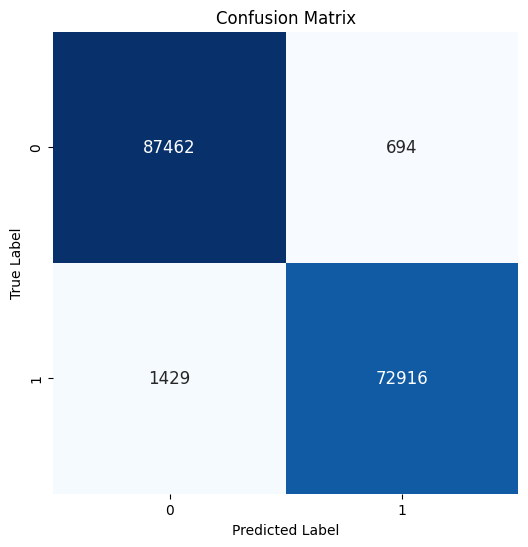

In [ ]:
# Confusion matrix visualization

cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 12})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

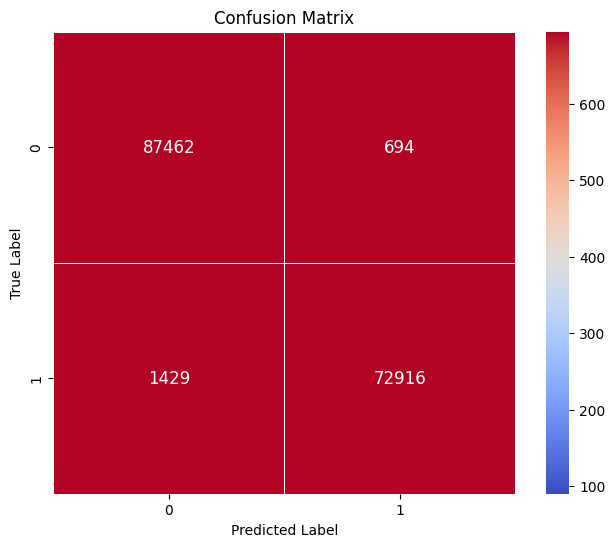

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you already have 'cm', 'test_labels', and 'y_pred' defined

# Create a more visually appealing color map
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Create the confusion matrix heatmap with modifications
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,  # Display the values in the cells
    fmt="d",     # Format of the cell values (integer)
    cmap=cmap,   # Use the custom color palette
    cbar=True,   # Display a color bar
    annot_kws={"size": 12},  # Adjust the font size of annotations
    linewidths=0.5,  # Add small linewidths between cells
    square=True,   # Ensure the heatmap is square-shaped
    vmax=100,      # Set the maximum color scale value
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


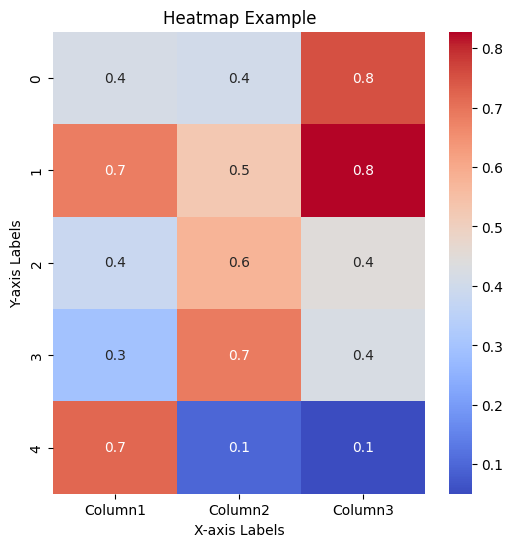

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a sample DataFrame with numerical values (replace this with your actual data)
data = {
    'Column1': np.random.rand(5),
    'Column2': np.random.rand(5),
    'Column3': np.random.rand(5)
}

df = pd.DataFrame(data)

# Create a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(df, annot=True, fmt=".1f", cmap="coolwarm", cbar=True)

# Add labels and title
plt.xlabel("X-axis Labels")
plt.ylabel("Y-axis Labels")
plt.title("Heatmap Example")

# Show the heatmap
plt.show()


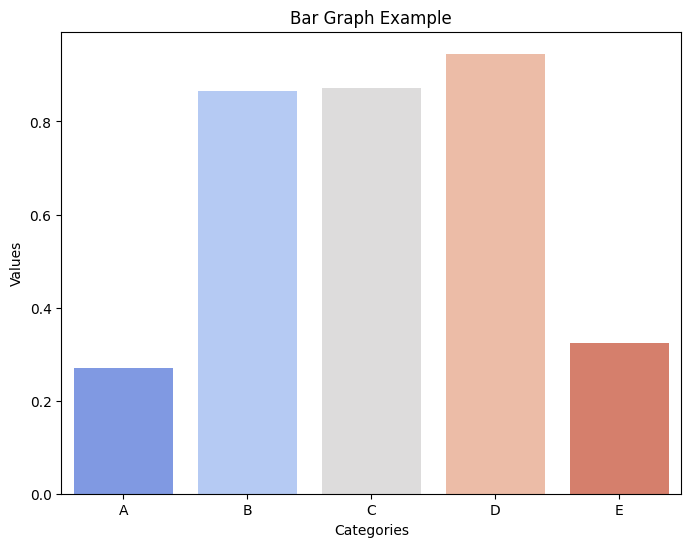

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a sample DataFrame with numerical values (replace this with your actual data)
data = {
    'Category': ['A', 'B', 'C', 'D', 'E'],
    'Value': np.random.rand(5)
}

df = pd.DataFrame(data)

# Create a bar graph
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='Category', y='Value', palette="coolwarm")

# Add labels and title
plt.xlabel("Categories")
plt.ylabel("Values")
plt.title("Bar Graph Example")

# Show the bar graph
plt.show()


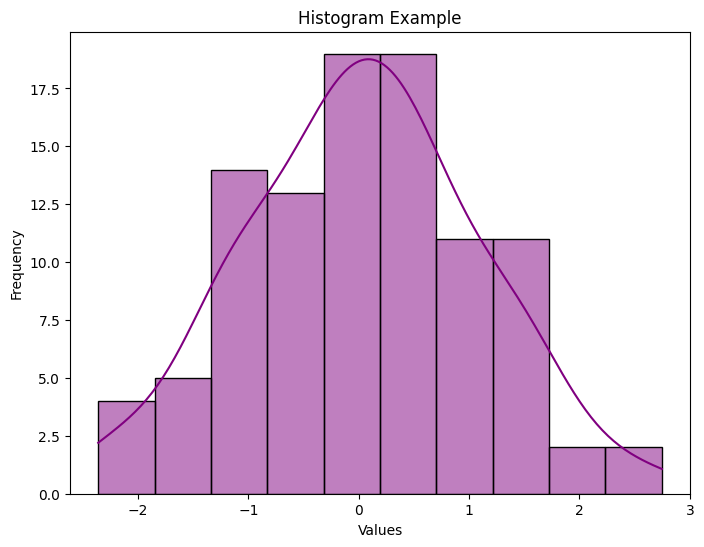

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a sample DataFrame with numerical values (replace this with your actual data)
data = {
    'Value': np.random.randn(100)  # Generating random data for the histogram
}

df = pd.DataFrame(data)

# Create a histogram
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Value', bins=10, kde=True, color='purple')

# Add labels and title
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Histogram Example")

# Show the histogram
plt.show()


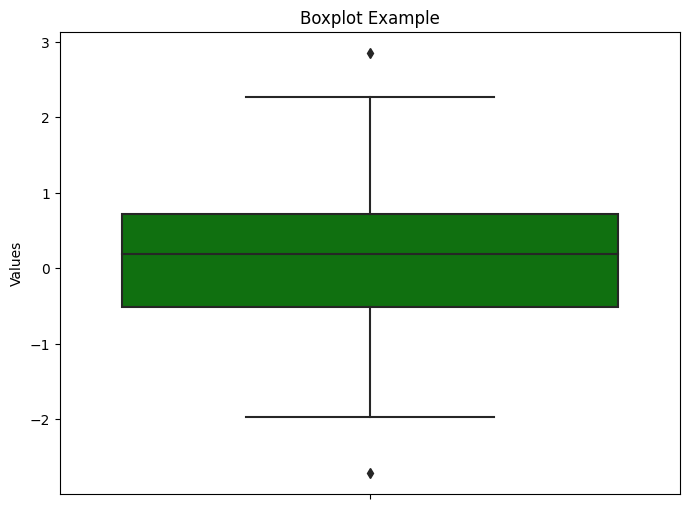

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a sample DataFrame with numerical values (replace this with your actual data)
data = {
    'Value': np.random.randn(100)  # Generating random data for the boxplot
}

df = pd.DataFrame(data)

# Create a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y='Value', color='green')

# Add labels and title
plt.ylabel("Values")
plt.title("Boxplot Example")

# Show the boxplot
plt.show()


In [ ]:
# Save the model
model.save('scam_detection_model.h5')

# Save the tokenizer for future use
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)

# Save the evaluation metrics
evaluation_metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1
}
pd.DataFrame(evaluation_metrics, index=[0]).to_csv('evaluation_metrics.csv', index=False)



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
